## Exploratory Analysis

In [189]:
import tensorflow as tf
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
import fnmatch
import pickle
%matplotlib inline

In [167]:
path = './audio/'
instruments = os.listdir('./audio/')

## Spectrogram

In [190]:
N_FFT = 2048 #Short-time Fourier transform (STFT)
def read_audio_spectrum(filename):
    x, fs = librosa.load(filename, sr=None)
    S = librosa.stft(x, N_FFT)
    #if x.ndim == 1:
        #x = np.expand_dims(x, 0)
    p = np.angle(S)
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

## Mel-frequency cepstral coefficients (MFCCs) 

In [191]:
def get_features(filename):
    y, sr = librosa.load(filename, sr=None)
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=20) #13 
    delta_mfcc = librosa.feature.delta(mfcc, mode='nearest')
    delta2_mfcc = librosa.feature.delta(mfcc, order=2, mode='nearest')
    feature_vector = np.concatenate((np.mean(mfcc,1), np.mean(delta_mfcc,1), np.mean(delta2_mfcc,1)))
    feature_vector = (feature_vector-np.mean(feature_vector)) / np.std(feature_vector)
    return feature_vector

## Getting samples

In [192]:
S_store = []
Mel_store = []
train_labels = []
for instrument in instruments:
    instrument_path = os.listdir(path+instrument+'/train') #lift all the files in the path
    for inst_path in instrument_path:
        train_labels.append(instrument)
        S, fs = read_audio_spectrum(path+instrument+'/train/'+inst_path)
        M = get_features(path+instrument+'/train/'+inst_path)
        S_store.append(S)
        Mel_store.append(M)

In [193]:
#Saving the matrix
with open('Spectrum_matrix', 'wb') as write:
    pickle.dump(S_store, write)
with open('MFCC_matrix', 'wb') as write:
    pickle.dump(Mel_store, write)

#with open ('Spectrum_matrix', 'rb') as read:
#    spectrum = pickle.load(read)
#with open ('MFCC_matrix', 'rb') as read:
#    mfcc = pickle.load(read)

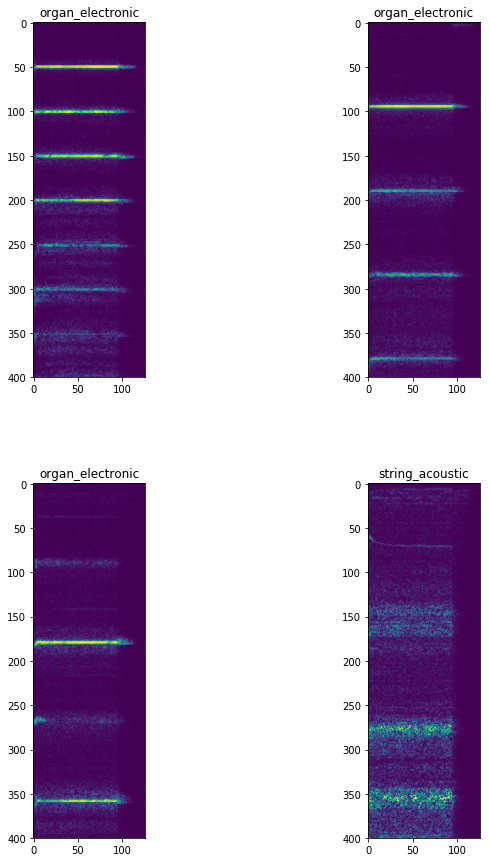

In [194]:
#Ploting the 
plt.figure(figsize=(10, 15))
plt.subplot(2, 2, 1)
plt.title(labels[0])
plt.imshow(S_store[0][:400,:]) #400 is tha maximum frequency range we want to plot. The matrix goes from 0 to 1000

plt.subplot(2, 2, 2)
plt.title(labels[30])
plt.imshow(S_store[30][:400,:])

plt.subplot(2, 2, 3)
plt.title(labels[60])
plt.imshow(S_store[60][:400,:])

plt.subplot(2, 2, 4)
plt.title(labels[110])
plt.imshow(S_store[110][:400,:])
plt.subplots_adjust(wspace=.5, hspace=.3)
plt.show()

## Getting test features

In [195]:
S_store_test = []
Mel_store_test = []
test_labels = []
for instrument in instruments:
    instrument_path = os.listdir(path+instrument+'/test') #lift all the files in the path
    for inst_path in instrument_path:
        test_labels.append(instrument)
        S, fs = read_audio_spectrum(path+instrument+'/test/'+inst_path)
        M = get_features(path+instrument+'/test/'+inst_path)
        S_store_test.append(S)
        Mel_store_test.append(M)
        
#Saving the matrix
with open('Spectrum_matrix_test', 'wb') as write:
    pickle.dump(S_store_test, write)
with open('MFCC_matrix_test', 'wb') as write:
    pickle.dump(Mel_store_test, write)

# Random Forest

In [196]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score,f1_score,roc_curve,auc,precision_recall_curve,average_precision_score,confusion_matrix

#### MFCC

In [209]:
train_features = np.zeros((len(Mel_store),len(Mel_store[0])))
for n,i in enumerate(Mel_store):
    train_features[n] = i

test_features = np.zeros((len(Mel_store_test),len(Mel_store_test[0])))
for n,i in enumerate(Mel_store_test):
    test_features[n] = i

In [212]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 10, oob_score= True) #min_impurity_decrease maybe too?
rf.fit(train_features, train_labels)
classif_predictions = rf.predict(test_features)   
classi_probe = rf.predict_proba(test_features)  
accuracy = accuracy_score(test_labels,classif_predictions,normalize=True)
f1 = f1_score(test_labels, classif_predictions, average='weighted') #Use labeled y-hat. Given that our classes present imbalance, we are going to use the weighted option;
print('Accuracy clasification score = %.3f' % accuracy)
print('F1 score = %.3f' % f1)
print('OOB score = %.3f' %rf.oob_score_)

Accuracy clasification score = 0.889
F1 score = 0.889
OOB score = 0.875


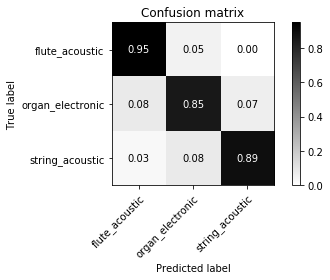

In [213]:
#Confusion matrix for multilevel classes
cm = confusion_matrix(test_labels, classif_predictions ,  labels=[inst for inst in instruments]) #use instruments
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes = unique_labels(test_labels, classif_predictions)
cmap=plt.cm.gray_r
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title=  'Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

#### Spectrum

In [214]:
train_features = np.array(S_store)
train_features = train_features.reshape(train_features.shape[0],-1)

test_features = np.array(S_store_test)
test_features = test_features.reshape(test_features.shape[0],-1)

In [215]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 10, oob_score= True) #min_impurity_decrease maybe too?
rf.fit(train_features, train_labels)
classif_predictions = rf.predict(test_features)   
classi_probe = rf.predict_proba(test_features)  
accuracy = accuracy_score(test_labels,classif_predictions,normalize=True)
f1 = f1_score(test_labels, classif_predictions, average='weighted') #Use labeled y-hat. Given that our classes present imbalance, we are going to use the weighted option;
print('Accuracy clasification score = %.3f' % accuracy)
print('F1 score = %.3f' % f1)
print('OOB score = %.3f' %rf.oob_score_)

Accuracy clasification score = 0.974
F1 score = 0.974
OOB score = 0.991


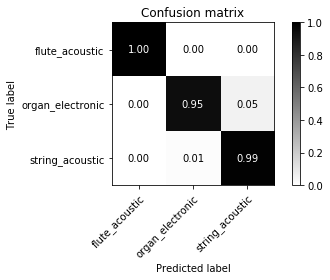

In [216]:
#Confusion matrix for multilevel classes
cm = confusion_matrix(test_labels, classif_predictions ,  labels=[inst for inst in instruments]) #use instruments
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes = unique_labels(test_labels, classif_predictions)
cmap=plt.cm.gray_r
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title=  'Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()